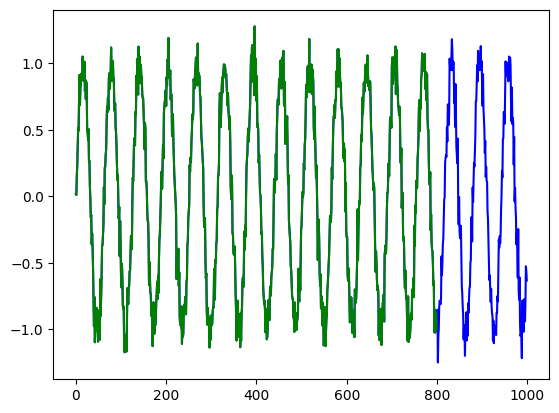

In [1]:
import numpy as np

def generate_data(n):
    x = np.arange(n)
    y = np.sin(x/10)+np.random.normal(0, 0.1, n)
    return y

data = generate_data(1000)
train_data = data[:800]
test_data = data[800:]

import matplotlib.pyplot as plt
plt.plot(data, color='blue')
plt.plot(train_data, color='green')
plt.show()

In [2]:
import torch 
import torch.nn as nn

class TFM(nn.Module):
    def __init__(self, input_size,output_size,hiddensize,num_layers,num_heads,dropout):
        super(TFM, self).__init__()
        self.hidden_size = hiddensize
        self.encoder = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(input_size, num_heads, hiddensize, dropout,batch_first=True),
                num_layers,
                )
        self.decoder = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        x = self.encoder(x)        
        x = self.decoder(x)
        return x

In [3]:
def preprocess_data(data, window_size):
    x = []
    y = []
    for i in range(len(data)-window_size):
        x.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(x), np.array(y)

window_size = 10
x_train, y_train = preprocess_data(train_data, window_size)
x_test, y_test = preprocess_data(test_data, window_size)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [4]:
model = TFM(input_size=window_size, output_size=1, hiddensize=256, num_layers=2, num_heads=2, dropout=0.1)
criterion = nn.MSELoss()

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train_dataset = TensorDataset(x_train,y_train)
batch_size = 32
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [6]:
opt = torch.optim.Adam(model.parameters(),lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
epoches = 1000
for epoch in range(epoches):
    totoal_loss = 0
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        l = criterion(y_hat,y)
        opt.zero_grad()
        totoal_loss += l.item()
        l.backward()
        opt.step()
    if epoch%50 == 0:
        print('epoch: {}, loss: {}'.format(epoch, totoal_loss))
        

/home/step/anaconda3/envs/xclds/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/step/anaconda3/envs/xclds/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, loss: 12.983481168746948
epoch: 50, loss: 12.34549629688263
epoch: 100, loss: 12.372141897678375
epoch: 150, loss: 12.223463594913483
epoch: 200, loss: 12.250466495752335
epoch: 250, loss: 12.313239067792892
epoch: 300, loss: 12.172571212053299
epoch: 350, loss: 12.222179621458054
epoch: 400, loss: 12.36153706908226
epoch: 450, loss: 12.238565891981125
epoch: 500, loss: 12.27391305565834
epoch: 550, loss: 12.009372562170029


KeyboardInterrupt: 

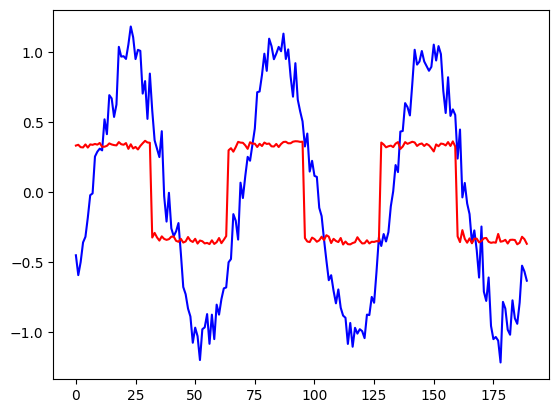

In [11]:
# model 接受的输入是 (seq_len, input_size)
test_dataset = TensorDataset(x_test,y_test)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
predict = []
for x,y in test_loader:
    x = x.to(device)
    predict.append(model(x))

plt.plot(y_test.detach().numpy(), color='blue')
plt.plot(torch.cat(predict).cpu().detach().numpy(), color='red')
    